<a href="https://colab.research.google.com/github/Naveensadanandan/Pytorch/blob/main/02_Neural_network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Make classification data and get it ready

In [94]:
from sklearn.datasets import make_circles


# Make 10000 samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.05, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

In [95]:
print(f"values in X : {X[:5]}")
print(f"dtype in X : {type(X)}")
print(f"shape of X : {X.shape}")

values in X : [[ 0.74220688  0.24668576]
 [-0.7340323   0.16869164]
 [-0.82985872  0.22195899]
 [-0.42913559  0.67223019]
 [ 0.44560223 -0.89493556]]
dtype in X : <class 'numpy.ndarray'>
shape of X : (1000, 2)


In [96]:
print(f"values in y : {y[:5]}")
print(f"dtype in y : {type(y)}")
print(f"shape of y : {y.shape}")

values in y : [1 1 1 1 0]
dtype in y : <class 'numpy.ndarray'>
shape of y : (1000,)


In [97]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
circles.head(10)

,X1,X2,label
0,0.742207,0.246686,1
1,-0.734032,0.168692,1
2,-0.829859,0.221959,1
3,-0.429136,0.672230,1
4,0.445602,-0.894936,0
5,-0.469885,0.708037,1
6,-0.016045,0.805623,1
7,0.759623,0.159526,1
8,-0.175692,-0.799837,1
9,-0.110616,1.042207,0


In [98]:
# Check different labels
circles.label.value_counts()

,count
label,
1,500
0,500


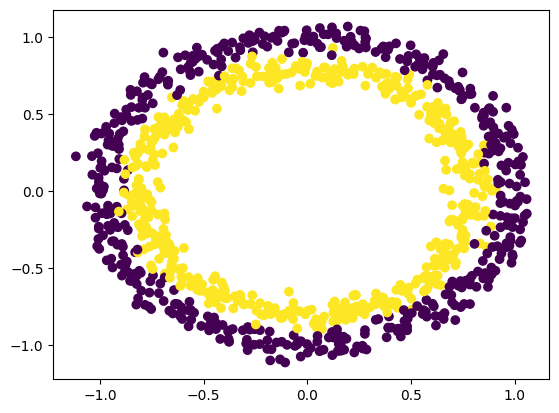

In [99]:
#plotting data points|
import matplotlib.pyplot as plt
plt.scatter(x = X[:,0],
            y = X[:,1],
            c = y)
plt.show()

##  1.1 Input and output shapes

In [100]:
print(f"shape of X : {X.shape}")
print(f"shape of y : {y.shape}")

shape of X : (1000, 2)
shape of y : (1000,)


## Convering data to tensors

In [101]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
print(X[0])

tensor([0.7422, 0.2467])


In [102]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Building a model for Binary ClASSIFICATION

In [103]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Defining the model

In [104]:
class CircleModelV0(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)

    self.layer1 = nn.Linear(in_features=2, out_features=10)
    self.layer2 = nn.Linear(in_features=10,out_features=10)
    self.layer3 = nn.Linear(in_features=10,out_features=1)

  def forward(self, X):
    return self.layer3(self.layer2(self.layer1(X)))

model_1 = CircleModelV0().to(device)

In [105]:
model_1.state_dict()

OrderedDict([('layer1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]])),
             ('layer1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984])),
             ('layer2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.1222, -0.2426,  0.2595,  0.0911,  0.1310

In [106]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_1.parameters(),
                            lr = 0.1)

In [107]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [108]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):

  model_1.train()

  #1.forward
  y_logits = model_1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  #2.loss

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)

  #3. zero grad
  optimizer.zero_grad()

  #4. backpropogation
  loss.backward()

  #5.gradient descent

  optimizer.step()

  #testing
  model_1.eval()

  with torch.inference_mode():
    test_logits = model_1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    # 2. Caculate loss/accuracy
    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                            y_pred=test_pred)
    # Print out what's happening every 10 epochs
    if epoch % 500 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")




Epoch: 0 | Loss: 0.69393, Accuracy: 51.00% | Test loss: 0.69264, Test acc: 50.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69465, Test acc: 45.50%


# Creating a model with non linear activation function

In [109]:
import torch
from torch import nn

class CircleModelV1(nn.Module):
  def __init__(self, *args, **kwargs) -> None:
     super().__init__(*args, **kwargs)
     self.layer1 = nn.Linear(in_features=2, out_features=10)
     self.layer2 = nn.Linear(in_features=10, out_features=10)
     self.layer3 = nn.Linear(in_features=10, out_features=1)
     self.relu = nn.ReLU()

  def forward(self, x):
    z = self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
    return z

model_2 = CircleModelV1()
model_2.to(device)

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [110]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_2.parameters(),
                            lr = 0.1)

In [111]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

epochs = 1000

for epoch in range(epochs):
  model_2.train()

  y_logits = model_2(X_train).squeeze()
  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_pred= y_preds, y_true = y_train)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_2.eval()

  with torch.inference_mode():
    test_logits = model_2(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_pred= test_preds, y_true = y_test)

    if epoch%250 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.69295, Accuracy: 50.00% | Test loss: 0.69329, Test acc: 50.00%
Epoch: 250 | Loss: 0.68891, Accuracy: 53.25% | Test loss: 0.68882, Test acc: 55.00%
Epoch: 500 | Loss: 0.68126, Accuracy: 53.62% | Test loss: 0.68084, Test acc: 56.00%
Epoch: 750 | Loss: 0.66143, Accuracy: 60.12% | Test loss: 0.66117, Test acc: 62.00%


In [112]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


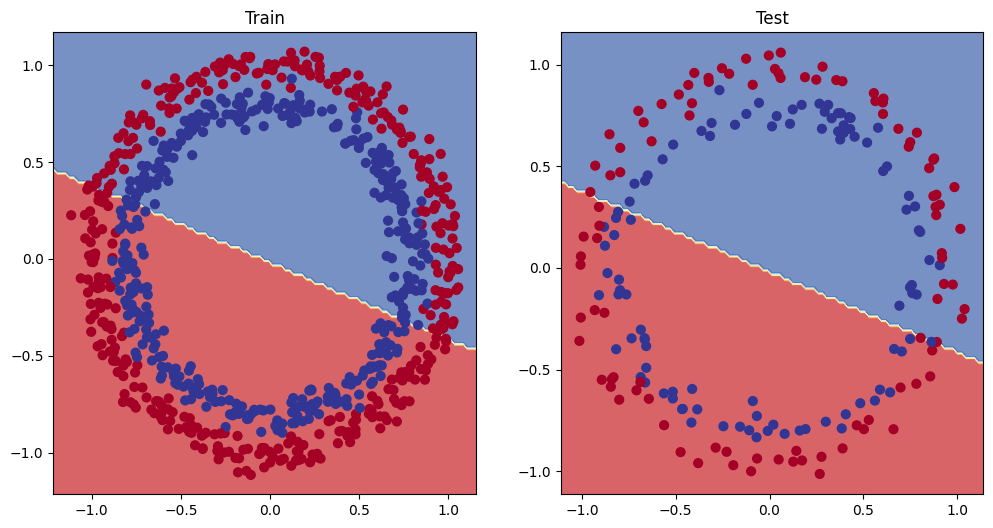

In [113]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

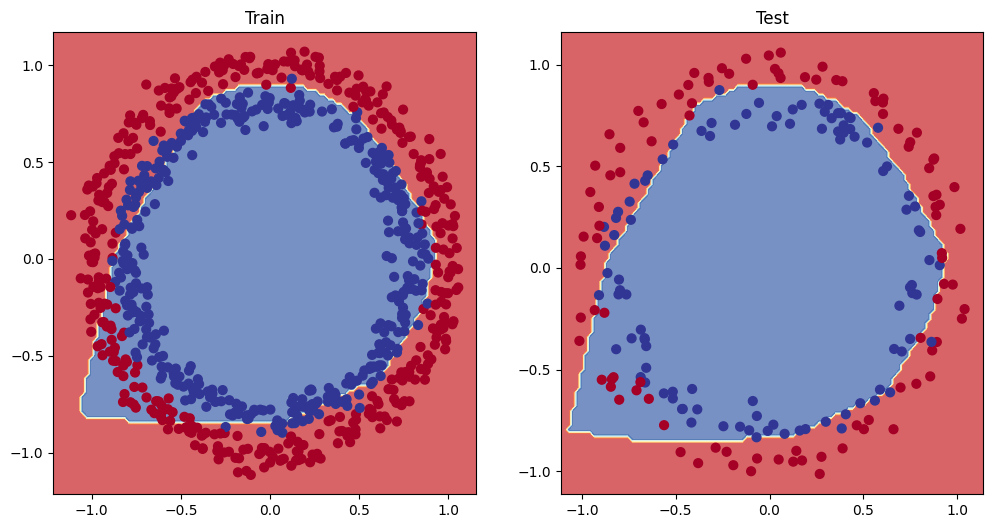

In [114]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

#Creating a Model for Multiclass Classification

## Preparing data using Blob datasets

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


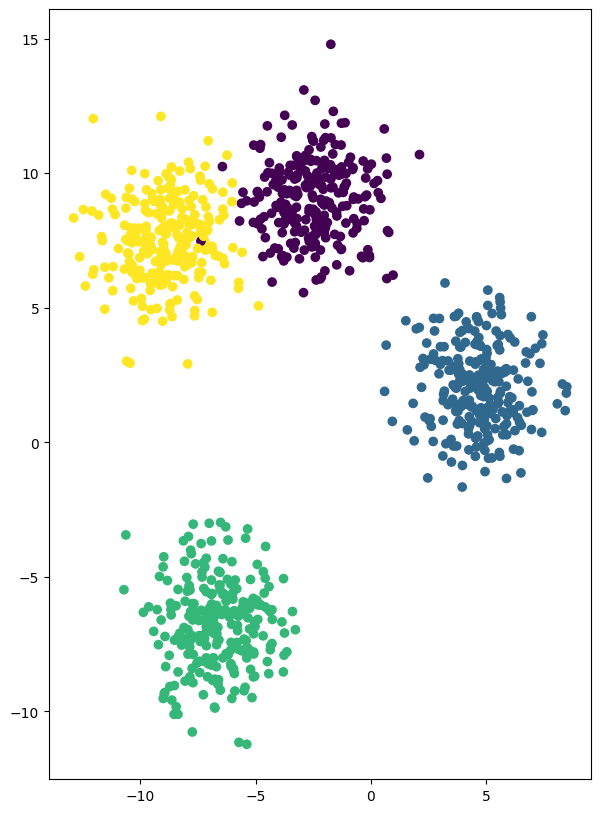

In [115]:
import torch
import numpy as np
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_SAMPLES = 1000
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42


X_blob, y_blob = make_blobs(n_samples=NUM_SAMPLES,
                  centers=NUM_CLASSES,
                  n_features=NUM_FEATURES,
                  cluster_std=1.5,
                  random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

X_train, X_test, y_train,y_test = train_test_split(X_blob,
                                                    y_blob,
                                                    test_size=0.25,
                                                    random_state=RANDOM_SEED)

plt.figure(figsize=(7,10))
plt.scatter(X_blob[:,0],X_blob[:,1],c = y_blob)
plt.show()

###Setting device

In [116]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [117]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units = 8, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self, X):
    return self.linear_layer_stack(X)

model3 = BlobModel(input_features = NUM_FEATURES,
                   output_features = NUM_CLASSES).to(device)
model3

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [118]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [119]:
loss_fn = torch.nn.CrossEntropyLoss()
optmizer = torch.optim.SGD(params = model3.parameters(), lr=0.1)

In [120]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
epochs = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model3.train()

  y_logits = model3(X_train)
  y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits , y_train)
  acc = accuracy_fn(y_true= y_train, y_pred = y_preds)

  optmizer.zero_grad()

  loss.backward()

  optmizer.step()

  model3.eval()

  with torch.inference_mode():
    test_logits = model3(X_test)
    test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

    test_loss = loss_fn(test_logits , y_test)
    test_acc = accuracy_fn(y_true= y_test, y_pred = test_preds)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")



Epoch: 0 | Loss: 1.16018, Acc: 39.47% | Test Loss: 1.06842, Test Acc: 53.20%
Epoch: 10 | Loss: 0.64578, Acc: 96.93% | Test Loss: 0.64848, Test Acc: 97.20%
Epoch: 20 | Loss: 0.42565, Acc: 98.53% | Test Loss: 0.42144, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25143, Acc: 99.07% | Test Loss: 0.23646, Test Acc: 99.60%
Epoch: 40 | Loss: 0.11139, Acc: 99.20% | Test Loss: 0.09790, Test Acc: 99.60%
Epoch: 50 | Loss: 0.06667, Acc: 99.20% | Test Loss: 0.05642, Test Acc: 99.60%
Epoch: 60 | Loss: 0.05136, Acc: 99.20% | Test Loss: 0.04138, Test Acc: 99.60%
Epoch: 70 | Loss: 0.04381, Acc: 99.20% | Test Loss: 0.03349, Test Acc: 99.60%
Epoch: 80 | Loss: 0.03920, Acc: 99.20% | Test Loss: 0.02862, Test Acc: 99.60%
Epoch: 90 | Loss: 0.03618, Acc: 99.20% | Test Loss: 0.02541, Test Acc: 99.60%


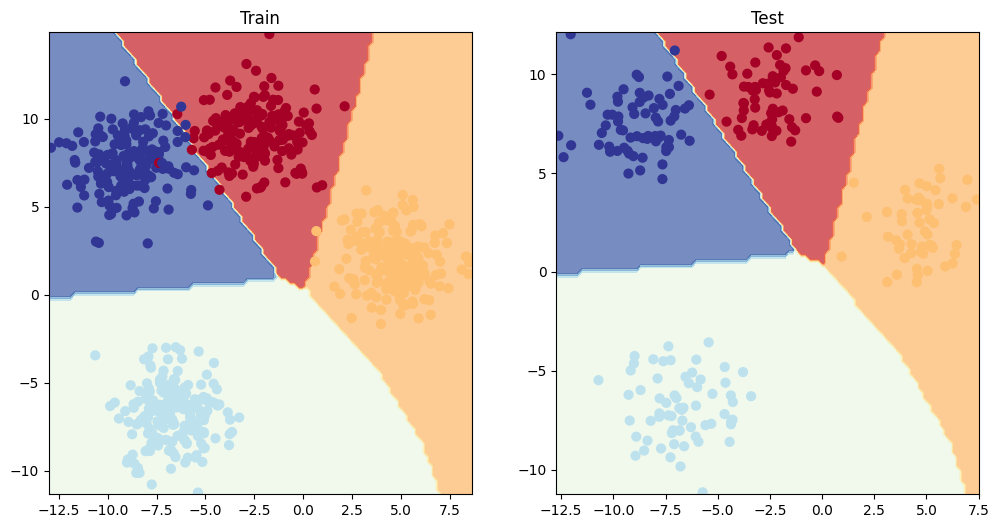

In [121]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model3, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model3, X_test, y_test)

In [122]:
try:
    from torchmetrics import Accuracy
except:
    !pip install torchmetrics==0.9.3 # this is the version we're using in this notebook (later versions exist here: https://torchmetrics.readthedocs.io/en/stable/generated/CHANGELOG.html#changelog)
    from torchmetrics import Accuracy

# Setup metric and make sure it's on the target device
torchmetrics_accuracy = Accuracy(task='multiclass', num_classes=4).to(device)

# Calculate accuracy
torchmetrics_accuracy(test_preds, y_test)

tensor(0.9960)

#Practise Excersices

Make a binary classification dataset with Scikit-Learn's make_moons() function.
For consistency, the dataset should have 1000 samples and a random_state=42.
Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [181]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import torch
from torch import nn
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42
NUM_FEATURES = 2
NUM_CLASSES = 1

X_moon, y_moon = make_moons(n_samples=1000, noise=0.2, random_state=42)

print(f"shape of x : {X_moon.shape}")
print(f"shape of y : {y_moon.shape}")

X_moon,y_moon = torch.from_numpy(X_moon).type(torch.float), torch.from_numpy(y_moon).type(torch.float)


X_train, X_test, y_train,y_test = train_test_split(X_moon,
                                                    y_moon,
                                                    test_size=0.25,
                                                    random_state=RANDOM_SEED)

shape of x : (1000, 2)
shape of y : (1000,)


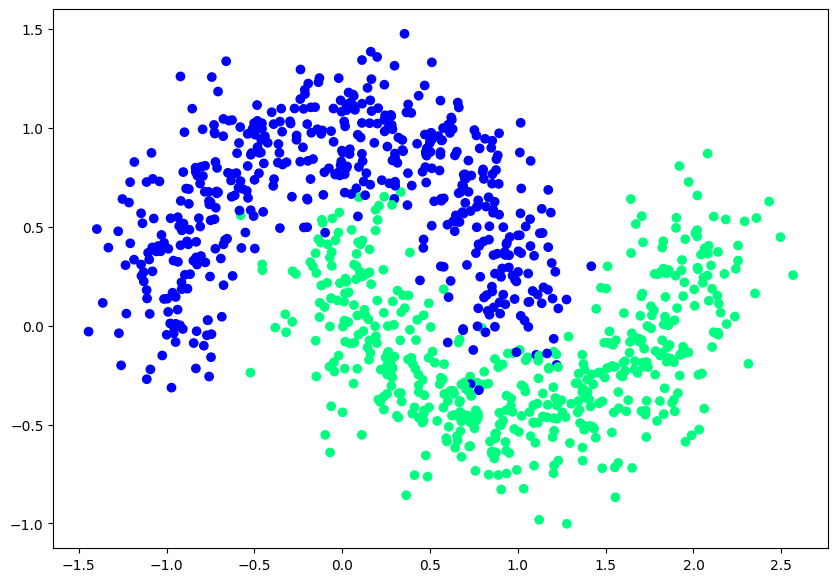

In [182]:
#visulalize to get a better view
plt.figure(figsize = (10,7))
plt.scatter(x = X_moon[:,0], y = X_moon[:,1], c = y_moon, cmap ="winter")
plt.show()

In [183]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.

In [184]:
class MakeMoon(nn.Module):
  def __init__(self,input_features, out_features, hidden_units = 8, *args, **kwargs) -> None:
     super().__init__(*args, **kwargs)
     self.linear_layer_stack = nn.Sequential(
         nn.Linear(in_features= NUM_FEATURES, out_features= hidden_units),
         nn.ReLU(),
         nn.Linear(in_features= hidden_units, out_features= hidden_units),
         nn.ReLU(),
         nn.Linear(in_features= hidden_units, out_features= NUM_CLASSES)
     )

  def forward(self, X):
    return self.linear_layer_stack(X)

model_4 = MakeMoon(input_features = NUM_FEATURES,
                   out_features = NUM_CLASSES).to(device)
model_4

MakeMoon(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

Setup a binary classification compatible loss function and optimizer to use when training the model.

In [185]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params = model_4.parameters(), lr = 0.1)

In [186]:
X_train

tensor([[ 0.0895,  0.5532],
        [ 0.4639,  0.0534],
        [-0.4420,  0.9528],
        ...,
        [-0.8699,  0.4856],
        [ 1.1463,  0.1942],
        [ 1.9414,  0.1495]])

Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
Train the model for long enough for it to reach over 96% accuracy.
The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [187]:
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
epochs = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_4.train()

  y_logits = model_4(X_train).squeeze()

  y_preds = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits, y_train)

  acc = accuracy_fn(y_true = y_train,
                    y_pred = y_preds)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_4.eval()

  with torch.inference_mode():
    test_logits = model_4(X_test).squeeze()
    test_preds = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_pred = test_preds, y_true= y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.71283, Acc: 49.47% | Test Loss: 0.70411, Test Acc: 51.60%
Epoch: 100 | Loss: 0.39929, Acc: 83.20% | Test Loss: 0.38421, Test Acc: 84.00%
Epoch: 200 | Loss: 0.29680, Acc: 86.27% | Test Loss: 0.25909, Test Acc: 88.80%
Epoch: 300 | Loss: 0.28460, Acc: 86.93% | Test Loss: 0.24383, Test Acc: 88.80%
Epoch: 400 | Loss: 0.27377, Acc: 87.60% | Test Loss: 0.23310, Test Acc: 89.20%
Epoch: 500 | Loss: 0.25812, Acc: 88.53% | Test Loss: 0.21840, Test Acc: 90.40%
Epoch: 600 | Loss: 0.23452, Acc: 90.00% | Test Loss: 0.19712, Test Acc: 91.20%
Epoch: 700 | Loss: 0.20318, Acc: 91.20% | Test Loss: 0.16903, Test Acc: 93.60%
Epoch: 800 | Loss: 0.17014, Acc: 93.87% | Test Loss: 0.13950, Test Acc: 94.00%
Epoch: 900 | Loss: 0.14293, Acc: 95.20% | Test Loss: 0.11501, Test Acc: 97.60%


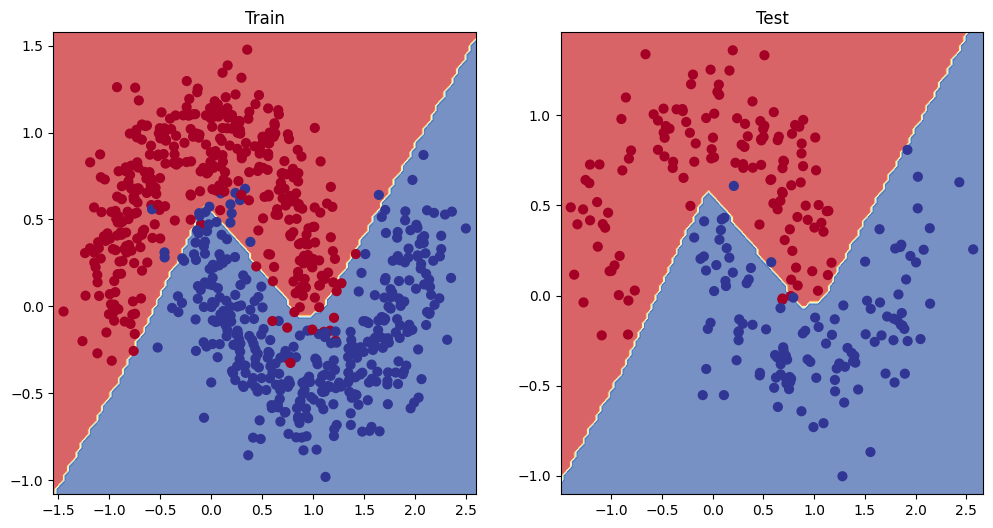

In [188]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_test, y_test)